In [1]:
# For symbolic calculations
import sympy as sp
# For numeric calculations
import numpy as np

# For plotting
import matplotlib.pyplot as plt

from inflationpy import SlowRollModel, SlowRollEndSolver, SlowRollStartSolver

# Notebook for calculating observables

\begin{equation}
    S = \int d^4x \sqrt{-g} \left\{ \frac{M_p^2}{2} A(\phi)R  -\frac{1}{2}B(\phi)g^{\mu \nu} \nabla_{\mu} \phi \nabla_{\nu} \phi -  V(\phi)  \right \}
\end{equation} 

## 1) Define model functions

To start calculating, required symbols must be defined. By default SlowRollModel assumes that 'phi' is used as scalar field ('I_phi' for invariant field) symbol and 'M_p' as Planck's mass. If other symbols are used then this information must be given to the SlowRollModel class.

To define symbols and equations it is advised to use sympy although it can try to convert strings to equations as well this method is not too reliable. To look more how to define functions with sympy: https://docs.sympy.org/latest/modules/functions/index.html#contents

In [2]:
# Define symbols. phi for scalar field and I_phi for invariant scalar field.
phi, I_phi = sp.symbols('phi I_phi', real=True)
# Define model specific free parameters and Planck's mass
alpha, M_p = sp.symbols('alpha M_p', real=True, positive=True)
# Also program uses some default symbols: 'N' for e-folds
N = sp.symbols('N', real=True, positive=True)

In [3]:
# Define functions. 
A = 1
B = 6*alpha/(phi-1)**2
V = (phi/M_p - 2)**2 * (phi/M_p)**2/((phi/M_p)**2 - 2*phi/M_p + 2)**2
I_V = sp.tanh(I_phi/(sp.sqrt(6*alpha)*M_p))**2

Put all functions into SlowRollModel class which then sets up all required combinations for later calculations. It is possible to define only some of the functions. Although to calculate observables (A, B, V) or invariant potential must be defined. 

When only invariant potential is defined then it is possible to use it two ways:
Set: A=1, B=1 and V=invariant potential or set I_V = invariant potential.

\begin{equation}
S = \int d^4x \sqrt{-g} \left\{ \frac{M_p^2}{2} R  -\frac{1}{2}g^{\mu \nu} \nabla_{\mu} I_\phi \nabla_{\nu} I_\phi -  I_V(I_\phi)  \right \} 
\end{equation}

Invariant functions are defined as:

\begin{equation}
    I_V = \frac{V}{A^2}
\end{equation}
\begin{equation}
    I_\phi = \int \sqrt{\frac{B}{A} + \delta_\Gamma \frac{3}{2} M_p^2 \left(\frac{A'}{A}\right)^2} d\phi
\end{equation}

where $\delta_\Gamma = 1$ for metric formalism and $0$ for Palatini.

SlowRollModel will calculate following equations:
1) Slow-roll parameters $\epsilon$ and $\eta$.
2) For scalar field $F(\phi) = \frac{B}{A} + \delta_\Gamma \frac{3}{2} M_p^2 \left(\frac{A'}{A}\right)^2$
3) Also N-fold integrand $\frac{AVF}{AV'-2VA'} = \frac{I_V'}{I_V}$
4) Observable functions from $\epsilon$ and $\eta$.

In [4]:
# A, B, V and I_V and functions which are possible to define
# palatini (True/False) - to use Palatini formalism or not
# symbol is set to phi (this is actually not required if phi=sp.Symbol('phi', real=True))
# Planck's mass symbol/value is set to M_p (this is actually not required if mp=sp.Symbol('M_p', real=True, positive=True))
model = SlowRollModel(A=A, B=B, V=V, I_V=I_V, palatini=False, symbol=phi, mp=M_p)
# Try to simplify all functions (also which are calculated in model). This might make later calculations easier/faster.
model.simplify()
model

A= 1
B= 6*alpha/(phi - 1)**2
V= phi**2*(-2 + phi/M_p)**2/(M_p**2*(2 - 2*phi/M_p + phi**2/M_p**2)**2)
I_V= tanh(sqrt(6)*I_phi/(6*M_p*sqrt(alpha)))**2

## 2) Calculate scalar field values at the end of inflation

#### This is defined by condtion:
\begin{equation}
\epsilon = 1
\end{equation}

In this paragraph is showed how to calculate field values for scalar field and invariant scalar field. Simply this requires to say solver if to use invariant potential or not.

In [5]:
# Use functions A, B and V to calculate inflation end value
end_solver = SlowRollEndSolver(model, invariant=False)

In [6]:
# Currently sympy couldn't find any analytical solution. Let's try some numerical solution.
analytical_end = end_solver.solve()
print(analytical_end)

[]


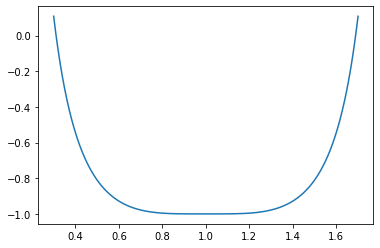

In [7]:
# To look beforehand where the roots might be let's calculate some function values
x = np.linspace(0.3, 1.7, 1000)
epsilon_values = model.epsilon.f_n(x, M_p=1, alpha=2)-1 # We have parameters M_p and alpha as free parameters. Assign some values
plt.plot(x, epsilon_values)
# We can see that there are two roots between [0, 2]. Let's calculate for range [0, 1].

In [8]:
# Results are in list, so take first value as this is what we wanted
# nsolve_np uses scipy method to find roots. It is also possible to use mpmath package with nsolve_mp
numerical_end = end_solver.nsolve_np([0, 1], params={M_p:1, alpha:2})[0]
print("End value for alpha=2, M_p=1 in range [0, 1]: ", numerical_end)

End value for alpha=2, M_p=1 in range [0, 1]:  0.3111619436993338


## 3) Calculate scalar field values at the beginning of inflation

#### Solve differential equation $\frac{d\phi}{dN} = \frac{AV' - 2VA'}{AVF}$ with initial condition ($\phi_{0} = \phi_{\text{end}}; \  N=0$)

In [9]:
# Use A, B and V functions to for calculations
initial_solver = SlowRollStartSolver(model, invariant=False)
# Calculate function phi_0(N) from N=0 to N=N_max. By default N_max = 100
initial_value_function = initial_solver.nsolve_np(end_value=numerical_end, N_max=100, params={"M_p":1, 'alpha':2})
# To calculate initial scalar field value at the N just insert required N value into the function
# initial_value_function(N) -> returns initial scalar field value at N. 
# To use mpmath for solver use nsolve_mp

In [10]:
print(f'Scalar field initial value with N=50: {initial_value_function(50)}')
print(f'Scalar field initial value with N=60: {initial_value_function(60)}')

Scalar field initial value with N=50: [0.87968121]
Scalar field initial value with N=60: [0.88978241]


## 4) Calculate values for observables at N=50 and N=60

This requires scalar field values at the start of inflation. Functions are already defined in model.

In [11]:
# Uses sympy to calculate ns and returns sp.Expr type value. To find numerical value for that use sp.N
n_s50 = model.calculate_ns(initial_value_function(50), params={M_p:1, alpha:2})
print('n_s (N=50) =', n_s50)
print('n_s (N=50) =', sp.N(n_s50[0]))
# Uses numpy to calculate ns. To use mpmath use calculate_ns_mp
n_s60 = model.calculate_ns_np(initial_value_function(60), params={M_p:1, alpha:2})
print('n_s (N=60) =', n_s60)

n_s (N=50) = [0.960253236166710]
n_s (N=50) = 0.960253236166710
n_s (N=60) = [0.96680393]


In [12]:
# Uses sympy to calculate ns and returns sp.Expr type value. To find numerical value for that use sp.N
r50 = model.calculate_r(initial_value_function(50), params={M_p:1, alpha:2})
print('n_s (N=50) =', r50)
print('n_s (N=50) =', sp.N(r50[0]))
# Uses numpy to calculate ns
r60 = model.calculate_r_np(initial_value_function(60), params={M_p:1, alpha:2})
print('n_s (N=60) =', r60)

n_s (N=50) = [0.00894549943140845]
n_s (N=50) = 0.00894549943140845
n_s (N=60) = [0.00629826]


## 4) Calculate observable values for invariant field

This time we try to calculate values for multiple alpha values. As analytical solution is not available we have to do it numerically. To make calculations faster without selecting values we assume that if multiple roots exist we select the closest to minimum.

In [13]:
end_solver2 = SlowRollEndSolver(model, invariant=True)
alpha_values = [1, 2, 4, 8, 16, 32, 64, 128, 256]

invariant_end_values = []
for alpha_value in alpha_values:
    # Select first root value (results are ordered from lowest to highest)
    calculated_end_value = end_solver2.nsolve_np([0, 5], params={alpha:alpha_value, M_p:1})[0]
    invariant_end_values.append(calculated_end_value)

In [14]:
initial_solver2 = SlowRollStartSolver(model, invariant=True)
invariant_initial_functions = []
for alpha_value, end_value in zip(alpha_values, invariant_end_values):
    # Find numerical functions phi(N)
    function = initial_solver.nsolve_np(end_value, params={alpha:alpha_value, M_p:1})
    invariant_initial_functions.append(function)

####  Finally we have all required to make plots

In [15]:
# Load latest observable results (published 2018 and 2021)
from inflationpy.data.data import load_planck_data
sigma1_ns, sigma1_r, sigma2_ns, sigma2_r = load_planck_data()

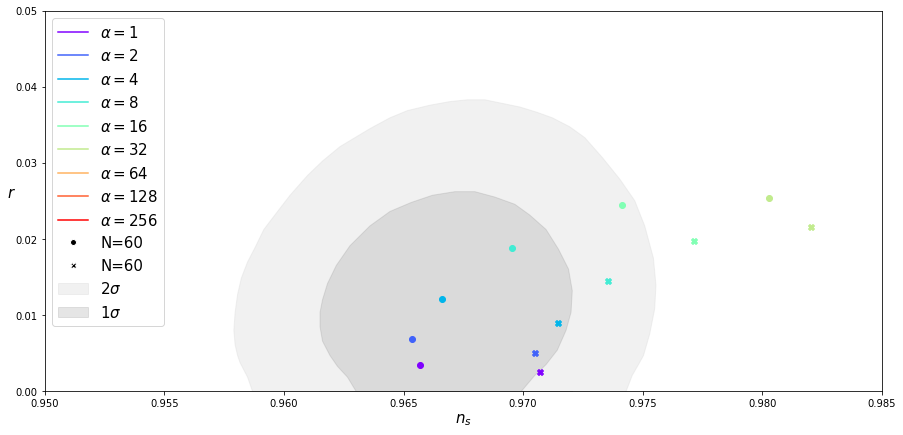

In [16]:
# Create matplotlib object
fig, ax = plt.subplots(figsize=(15, 7))
fontsize = 15

ax.set_ylim(0, 0.05)
ax.set_xlim(0.95, 0.985)
ax.set_xlabel("$n_s$", fontsize=fontsize)
ax.set_ylabel("$r$", fontsize=fontsize, rotation=0)

ax.fill_between(sigma2_ns, sigma2_r, label='$2\\sigma$', color='lightgrey', alpha=0.3)
ax.fill_between(sigma1_ns, sigma1_r, label='$1\\sigma$', color='grey', alpha=0.2)

color_iterator = plt.cm.rainbow(np.linspace(0, 1, len(alpha_values)))
# Plot n_s and r points
for initial_function, alpha_value, color in zip(invariant_initial_functions, alpha_values, color_iterator):
    ax.scatter(
        model.calculate_ns_np(initial_function([50]), params={alpha:alpha_value, M_p:1}),
        model.calculate_r_np(initial_function([50]), params={alpha:alpha_value, M_p:1}),
        color=color, marker='o')
    ax.scatter(
        model.calculate_ns_np(initial_function([60]), params={alpha:alpha_value, M_p:1}),
        model.calculate_r_np(initial_function([60]), params={alpha:alpha_value, M_p:1}),
        color=color, marker='X')

custom_legend = []
for alpha_value, c in zip(alpha_values, color_iterator):
    custom_legend.append(plt.Line2D([0], [0], color=c, linestyle='-', label=f'$\\alpha={alpha_value}$'))
custom_legend.append(plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='black', label='N=60'))
custom_legend.append(plt.Line2D([0], [0], marker='X', color='white', markerfacecolor='black', label='N=60'))
old_handles, old_labels = ax.get_legend_handles_labels()
custom_legend = custom_legend + old_handles
ax.legend(handles=custom_legend, fontsize=fontsize)

plt.show()